 ## TensorFlow Models repository

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2824, done.
remote: Counting objects: 100% (2824/2824), done.
remote: Compressing objects: 100% (2354/2354), done.
remote: Total 2824 (delta 722), reused 1282 (delta 435), pack-reused 0
Receiving objects: 100% (2824/2824), 32.82 MiB | 3.49 MiB/s, done.
Resolving deltas: 100% (722/722), done.


## Protobuf Installation/Compilation

* Install protobuf

In [ ]:
!sudo apt install -y protobuf-compiler

* compile proto model config file to pd2 

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

* install tensorflow object detection API

In [ ]:
%%bash
cd models/research/
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1660307 sha256=034f61a68d969516fd0428923beeefecec4e092584159338c89d5a2ab4dd0dc4
  Stored in directory: /tmp/pip-ephem-wheel-cache-013uk9cv/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=f720a8303741fedf072183f1f486c5931e80cc16e2ba013f1a0d3503e1aba038
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=6bd43d47606bf63313aa75349ce9b2a676d6277a76e53be985d5bbdb9d6e0fb4
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=3608a15c1684e3364f5ce7171eeed8efee88c61b841c10f70

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Download Dataset

In [ ]:
!git clone "https://github.com/experiencor/raccoon_dataset.git"

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (412/412), done.


In [ ]:
%%bash
mkdir -p ./dataset/tfrecord
mkdir -p ./dataset/csv

In [ ]:
label_map_path = 'label_map.pbtxt'

xml_dir = '/content/raccoon_dataset/annotations'
image_dir = '/content/raccoon_dataset/images'

tf_record_path = '/content/dataset/tfrecord/train.tfrecords'
csv_path = '/content/dataset/csv/train.csv'

## Create Label Map

In [ ]:
from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from google.protobuf import text_format

In [ ]:
msg = StringIntLabelMap()

In [ ]:
classes=['raccoon']

In [ ]:
for idx, name in enumerate(classes, start=1):
  item = StringIntLabelMapItem(id=idx, name=name, display_name=name)
  msg.item.append(item)

In [ ]:
text = str(text_format.MessageToBytes(msg, as_utf8=True), 'utf-8')

In [ ]:
with open(label_map_path, 'w') as f:
  f.write(text)

## Convert *.xml to *.record

In [ ]:
import os
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import tensorflow as tf
from PIL import Image
from object_detection.utils import dataset_util, label_map_util
from collections import namedtuple

In [ ]:
label_map = label_map_util.load_labelmap(label_map_path)

In [ ]:
label_map_dict = label_map_util.get_label_map_dict(label_map)

In [ ]:
# 1. xml load
tree = ET.parse('/content/raccoon_dataset/annotations/raccoon-1.xml')

# 2. xml 파일에서 필요 정보 추출
root = tree.getroot()
filename = root.find('filename').text
width = int(root.find('size').find('width').text)
height = int(root.find('size').find('height').text)

name = root.find('object').find('name').text

bndbox = root.find('object').find('bndbox')
xmin = int(bndbox.find('xmin').text)
ymin = int(bndbox.find('ymin').text)
xmax = int(bndbox.find('xmax').text)
ymax = int(bndbox.find('ymax').text)

# 3. 추출된 정보을 csv 포멧 적용(filename, with, height, ..)

In [ ]:
xml_list = []

for xml_file in glob.glob(xml_dir + '/*.xml'):
  # 1. xml load
  tree = ET.parse(xml_file)

  # 2. xml 파일에서 필요 정보 추출
  root = tree.getroot()
  filename = root.find('filename').text
  width = int(root.find('size').find('width').text)
  height = int(root.find('size').find('height').text)

  for object_tag in root.findall('object'):
    bndbox = object_tag.find('bndbox')
    value = (filename,
             width,
             height,
             object_tag.find('name').text,
             int(bndbox.find('xmin').text),
             int(bndbox.find('ymin').text),
             int(bndbox.find('xmax').text),
             int(bndbox.find('ymax').text))
    xml_list.append(value)

In [ ]:
column_name = ['filename', 'width', 'height',
                'class', 'xmin', 'ymin', 'xmax', 'ymax']

In [ ]:
df_xml = pd.DataFrame(xml_list, columns=column_name)

In [ ]:
df_xml

In [ ]:
data = namedtuple('data', ['filename', 'object'])

In [ ]:
df_group = df_xml.groupby('filename')

In [ ]:
df_group.groups.keys()

dict_keys(['raccoon-1.jpg', 'raccoon-10.jpg', 'raccoon-100.jpg', 'raccoon-101.jpg', 'raccoon-102.jpg', 'raccoon-103.jpg', 'raccoon-104.jpg', 'raccoon-105.jpg', 'raccoon-106.jpg', 'raccoon-107.jpg', 'raccoon-108.jpg', 'raccoon-109.jpg', 'raccoon-11.jpg', 'raccoon-110.jpg', 'raccoon-111.jpg', 'raccoon-112.jpg', 'raccoon-113.jpg', 'raccoon-114.jpg', 'raccoon-115.jpg', 'raccoon-116.jpg', 'raccoon-117.jpg', 'raccoon-118.jpg', 'raccoon-119.jpg', 'raccoon-12.jpg', 'raccoon-120.jpg', 'raccoon-121.jpg', 'raccoon-122.jpg', 'raccoon-123.jpg', 'raccoon-124.jpg', 'raccoon-125.jpg', 'raccoon-126.jpg', 'raccoon-127.jpg', 'raccoon-128.jpg', 'raccoon-129.jpg', 'raccoon-13.jpg', 'raccoon-130.jpg', 'raccoon-131.jpg', 'raccoon-132.jpg', 'raccoon-133.jpg', 'raccoon-134.jpg', 'raccoon-135.jpg', 'raccoon-136.jpg', 'raccoon-137.jpg', 'raccoon-138.jpg', 'raccoon-139.jpg', 'raccoon-14.jpg', 'raccoon-140.jpg', 'raccoon-141.jpg', 'raccoon-142.jpg', 'raccoon-143.jpg', 'raccoon-144.jpg', 'raccoon-145.jpg', 'raccoon

In [ ]:
df_group.get_group('raccoon-168.jpg')

In [ ]:
grouped = [data(filename, df_group.get_group(filename)) for filename in df_group.groups.keys()]

In [ ]:
def create_tf_example(group, path):
  with tf.io.gfile.GFile (os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
    encoded_jpg = fid.read()
  encoded_jpg_io = io.BytesIO(encoded_jpg)
  image = Image.open(encoded_jpg_io)
  width, height = image.size

  filename = group.filename.encode('utf8')
  image_format = b'jpg'
  xmins = []
  xmaxs = []
  ymins = []
  ymaxs = []
  classes_text = []
  classes = []

  for index, row in group.object.iterrows():
      xmins.append(row['xmin'] / width)
      xmaxs.append(row['xmax'] / width)
      ymins.append(row['ymin'] / height)
      ymaxs.append(row['ymax'] / height)
      classes_text.append(row['class'].encode('utf8'))
      classes.append(label_map_dict[row['class']])

  tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
  }))
  return tf_example

In [ ]:
writer = tf.io.TFRecordWriter(tf_record_path)

for group in grouped:
  tf_example = create_tf_example(group, image_dir)
  writer.write(tf_example.SerializeToString())

writer.close()

In [ ]:
df_xml.to_csv(csv_path, index=None)

## Download model

In [ ]:
model_path = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz'

In [ ]:
model_dir = tf.keras.utils.get_file(fname='ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz', 
                                    origin=model_path,
                                    cache_dir='/content',
                                    cache_subdir='pre-trained-models',
                                    untar=True)

244817920/244817203 [==============================] - 3s 0us/step


## Train Model

* configure the training pipline

In [ ]:
!mkdir -p ./train_model/my_ssd_resnet50_v1_fpn

In [ ]:
!cp /content/pre-trained-models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config ./train_model/my_ssd_resnet50_v1_fpn

* training_model

In [ ]:
from object_detection import model_lib_v2

In [ ]:
tf.config.set_soft_device_placement(True)
strategy = tf.compat.v2.distribute.MirroredStrategy()

In [ ]:
with strategy.scope():
  model_lib_v2.train_loop(
      pipeline_config_path='/content/train_model/my_ssd_resnet50_v1_fpn/pipeline.config',
      model_dir='/content/train_model/my_ssd_resnet50_v1_fpn',
      train_step=1000)

INFO:tensorflow:Maybe overwriting train_step: 1000


[08/09 03:17:37] tensorflow INFO: Maybe overwriting train_step: 1000


INFO:tensorflow:Ignoring config override key: train_step


[08/09 03:17:37] tensorflow INFO: Ignoring config override key: train_step


INFO:tensorflow:Maybe overwriting train_steps: None


[08/09 03:17:37] tensorflow INFO: Maybe overwriting train_steps: None


INFO:tensorflow:Maybe overwriting use_bfloat16: False


[08/09 03:17:37] tensorflow INFO: Maybe overwriting use_bfloat16: False


Instructions for updating:
rename to distribute_datasets_from_function


[08/09 03:17:37] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:558: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from_function


INFO:tensorflow:Reading unweighted datasets: ['/content/dataset/tfrecord/train.tfrecords']


[08/09 03:17:37] tensorflow INFO: Reading unweighted datasets: ['/content/dataset/tfrecord/train.tfrecords']


INFO:tensorflow:Reading record datasets for input file: ['/content/dataset/tfrecord/train.tfrecords']


[08/09 03:17:37] tensorflow INFO: Reading record datasets for input file: ['/content/dataset/tfrecord/train.tfrecords']


INFO:tensorflow:Number of filenames to read: 1


[08/09 03:17:37] tensorflow INFO: Number of filenames to read: 1


[08/09 03:17:37] tensorflow WARNING: num_readers has been reduced to 1 to match input file shards.


Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.


[08/09 03:17:37] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/object_detection/builders/dataset_builder.py:105: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.


Instructions for updating:
Use `tf.data.Dataset.map()


[08/09 03:17:37] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/object_detection/builders/dataset_builder.py:237: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


[08/09 03:17:46] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:206: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


[08/09 03:17:50] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:206: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


Instructions for updating:
Use `tf.cast` instead.


[08/09 03:17:52] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:464: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Instructions for updating:
Use fn_output_signature instead


[08/09 03:18:39] tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/deprecation.py:602: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead


KeyboardInterrupt: ignored

## Imports and Setup

In [ ]:
import pathlib

import matplotlib.pyplot as plt

import scipy.misc
import numpy as np
from six import BytesIO
from PIL import ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf

tf.get_logger().setLevel('ERROR')

## Utilities

In [ ]:
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [ ]:
category_index = {1: {'id': 1, 'name': 'raccon', 'display_name': 'raccon'}}

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(label_map_dict, use_display_name=True)

## Load model

In [ ]:
config_path = '/content/train_model/my_ssd_resnet50_v1_fpn/pipeline.config'

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(config_path)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

In [ ]:
ckpt_path = '/content/train_model/my_ssd_resnet50_v1_fpn/ckpt-2'

In [ ]:
# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(ckpt_path).expect_partial()

## Loading an image

In [ ]:
%matplotlib inline

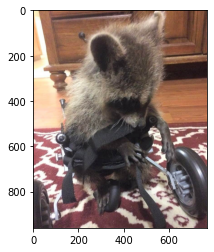

In [ ]:
image_path = '/content/raccoon_dataset/images/raccoon-111.jpg'
image_np = np.array(Image.open('/content/raccoon_dataset/images/raccoon-111.jpg'))

plt.figure()
plt.imshow(image_np)
plt.show()

## Doing the inference

In [ ]:
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

In [ ]:
image, shapes = detection_model.preprocess(input_tensor)
prediction_dict = detection_model.predict(image, shapes)
detections = detection_model.postprocess(prediction_dict, shapes)

In [ ]:
result = {key:value.numpy() for key,value in detections.items()}

In [ ]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

In [ ]:
viz_utils.visualize_boxes_and_labels_on_image_array(
      image=image_np_with_detections,
      boxes=result['detection_boxes'][0],
      classes=(result['detection_classes'][0] + label_id_offset).astype(int),
      scores=result['detection_scores'][0],
      category_index=category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30)

In [ ]:
plt.figure()
plt.imshow(image_np_with_detections)
plt.show()